## **Solving differential equations using PINNs**

**Our first problem is to solve:**

\begin{equation*}
    y'(x) = y(x) \quad y(0) = 1
\end{equation*}

In [1]:
# Importing libraries
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import sympy as smp

plt.style.use('fivethirtyeight')

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# Setting up the ODE problem: y' - y = 0
differential_equation = lambda x, y: dde.grad.jacobian(y, x, i = 0, j = 0) - y

# Exact solution
solution = lambda x: np.exp(x)

### **DeepXDE `jacobian` Function Documentation**  

---

#### **Purpose**  
Computes the **Jacobian matrix** $J$ of outputs y with respect to inputs x, where:

\begin{equation*}
   J[i, j] = \frac{\partial y_i}{\partial x_j}
\end{equation*}  

Designed for efficient first-order derivative calculations in physics-informed neural networks (PINNs).

#### **Parameters**  

| Parameter | Type | Description |  
|-----------|------|-------------|  
| `ys` | `Tensor` | Output tensor of shape `(batch_size, dim_y)` or `(batch_size_out, batch_size, dim_y)`. |  
| `xs` | `Tensor` | Input tensor of shape `(batch_size, dim_x)`. |  
| `i` | `int` or `None` | Row index. If `None`, returns the `j`-th column. |  
| `j` | `int` or `None` | Column index. If `None`, returns the `i`-th row. |  

**Constraints**:  
- `i` and `j` cannot both be `None` (unless the Jacobian is a single value).  

#### **Returns**  
| Return Type | Shape | Description |  
|-------------|-------|-------------|  
| `J[i, j]` | `(batch_size, 1)` or `(batch_size_out, batch_size, 1)` | Single entry of the Jacobian. |  
| `J[i, :]` | `(batch_size, dim_x)` or `(batch_size_out, batch_size, dim_x)` | Full row (gradient of \( y_i \)). |  
| `J[:, j]` | `(batch_size, dim_y)` or `(batch_size_out, batch_size, dim_y)` | Full column. |   

#### **Example Scenarios**  
1. **Single Entry**:  
   ```python  
   # Compute ∂y_0/∂x_1  
   dy0_dx1 = dde.grad.jacobian(y, x, i=0, j=1)  
   ```  

2. **Full Gradient of One Output**:  
   ```python  
   # Compute ∇y_0 (all partial derivatives of y_0)  
   grad_y0 = dde.grad.jacobian(y, x, i=0, j=None)  
   ```  

3. **Full Column (All Outputs w.r.t. One Input)**:  
   ```python  
   # Compute ∂y/∂x_0  
   dy_dx0 = dde.grad.jacobian(y, x, i=None, j=0)  
   ```  
---

In [3]:
# Creating the interval domain: from x = 0 to x = 3
domain = dde.geometry.Interval(0, 3)

In [4]:
# Defining the Dirichlet boundaries
initial_condition = dde.icbc.DirichletBC(
                                        geom = domain,
                                        func = lambda _: 1, 
                                        on_boundary = lambda x, _: np.isclose(x[0], 0),
                                        component = 0
                                        )

### **Boundary Conditions Overview**  
Boundary conditions (BCs) constrain the solution of differential equations at domain boundaries. DeepXDE provides flexible BC implementations for PINNs.

### **Base Class: `BC`**  
*Abstract base class for all boundary conditions.*  

#### **Key Parameters**  
| Parameter | Type | Description |  
|-----------|------|-------------|  
| `geom` | `Geometry` | Domain geometry (e.g., `Interval`, `Rectangle`). |  
| `on_boundary` | `Callable` | Function `(x, on_boundary) -> bool` to identify boundary points. |  
| `component` | `int` | Output component index to which the BC applies (default: `0`). |  

#### **Key Methods**  
| Method | Purpose |  
|--------|---------|  
| `collocation_points(X)` | Selects boundary points from input `X`. |  
| `error(X, inputs, outputs, ...)` | Computes the BC loss (must be implemented by subclasses). |  
| `filter(X)` | Filters boundary points from collocation data. |  

### **Concrete Implementation of the DirichletBC**  

#### **`DirichletBC`**  
*Enforces fixed values on boundaries (e.g., $y(\text{boundary}) = f(x)$).*  

##### **Parameters**  
| Parameter | Description |  
|-----------|-------------|  
| `func` | `Callable` prescribing the boundary values. Takes input coordinates `x` and returns the target value. |  

##### **Example**  
```python  
# Enforce y = sin(x) at x = 0  
bc = dde.icbc.DirichletBC(  
    geom=geometry,  
    func=lambda x: np.sin(x[:, 0:1]),  # y = sin(x) at boundary  
    on_boundary=lambda x, _: np.isclose(x[0], 0),  # Points where x=0  
    component=0  # Applies to the first output  
)  
```

---

In [5]:
# Configuring training data
data = dde.data.PDE(
                    geometry = domain,
                    pde = differential_equation,
                    bcs = [initial_condition],
                    train_distribution = "Hammersley",
                    num_domain = 1000,
                    num_boundary = 2,
                    num_test = 500,
                    solution = solution
                    )

### **DeepXDE PDE Class Documentation**  
*Physics-Informed Neural Network (PINN) Configuration for Solving ODEs/PDEs*

### **1. Core Functionality**  
The `PDE` class configures neural networks to solve:  
- **Ordinary Differential Equations (ODEs)**  
- **Time-Independent Partial Differential Equations (PDEs)**  

### **2. Key Parameters**  

### **Problem Definition**  
| Parameter | Type | Description |  
|-----------|------|-------------|  
| `geometry` | `Geometry` | Domain specification (e.g., `Interval`, `Rectangle`, `TimeDomain`). |  
| `pde` | `Callable` or `List[Callable]` | PDE residual function(s). Returns `0` when satisfied. |  
| `bcs` | `List[BC]` | Boundary/initial conditions (empty list `[]` if none). |  

### **Training Configuration**  
| Parameter | Default | Description |  
|-----------|---------|-------------|  
| `num_domain` | `0` | Collocation points inside the domain. |  
| `num_boundary` | `0` | Points on boundaries (for BC enforcement). |  
| `train_distribution` | `"Hammersley"` | Sampling method: `"uniform"`, `"pseudo"`, `"LHS"`, `"Halton"`, `"Sobol"`. |  

### **Validation & Advanced**  
| Parameter | Description |  
|-----------|-------------|  
| `solution` | Analytical solution (optional, for error computation). |  
| `num_test` | Test points for validation (defaults to training data if `None`). |  
| `auxiliary_var_function` | Adds external variables (e.g., parameters) to inputs. |  

### **3. Key Attributes**  

### **Training Data**  
| Attribute | Description |  
|-----------|-------------|  
| `train_x_all` | Collocation points (unordered, no duplicates). |  
| `train_x_bc` | Boundary condition points. |  
| `train_x` | Combined training data (BCs first, then PDE points). |  

### **Testing Data**  
| Attribute | Description |  
|-----------|-------------|  
| `test_x` | Test points (same BC points as training). |  

### **4. Methods**  

### **Data Management**  
| Method | Purpose |  
|--------|---------|  
| `add_anchors()` | Add fixed training points. |  
| `resample_train_points()` | Re-generate training points. |  

### **Training/Testing**  
| Method | Purpose |  
|--------|---------|  
| `train_next_batch()` | Fetch training data. |  
| `test()` | Generate test dataset. |    

---

In [6]:
# Creating the neural network
neural_network = dde.nn.FNN(
                            layer_sizes = [1] + [50] * 3 + [1],  # 1 input → 3 hidden layers (50 neurons each) → 1 output
                            activation = "tanh",
                            kernel_initializer = "Glorot normal"
                            )

neural_network.apply_output_transform(lambda x, y: y * x + 1) # Ensure y(0) = 1

In [7]:
# Creating the model
model = dde.Model(
                  data = data,
                  net = neural_network
                  )

In [8]:
# Training phase 1: Adam optimizer
model.compile(
              optimizer = "adam",
              lr = 1e-03,
              metrics = ["l2 relative error"]
              )

model.train(iterations = 15_000)

Compiling model...
'compile' took 3.209776 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.04e+00, 0.00e+00]    [1.04e+00, 0.00e+00]    [9.07e-01]    
1000      [7.45e-05, 0.00e+00]    [7.21e-05, 0.00e+00]    [2.80e-04]    
2000      [2.97e-05, 0.00e+00]    [2.88e-05, 0.00e+00]    [2.94e-04]    
3000      [7.77e-04, 0.00e+00]    [7.73e-04, 0.00e+00]    [2.63e-03]    
4000      [6.74e-06, 0.00e+00]    [6.38e-06, 0.00e+00]    [9.91e-05]    
5000      [8.75e-06, 0.00e+00]    [8.38e-06, 0.00e+00]    [1.65e-04]    
6000      [2.14e-06, 0.00e+00]    [1.95e-06, 0.00e+00]    [4.00e-05]    
7000      [1.40e-06, 0.00e+00]    [1.25e-06, 0.00e+00]    [2.57e-05]    
8000      [6.96e-06, 0.00e+00]    [6.76e-06, 0.00e+00]    [2.91e-04]    
9000      [9.11e-07, 0.00e+00]    [8.07e-07, 0.00e+00]    [1.79e-05]    
10000     [7.91e-07, 0.00e+00]    [6.99e-07, 0.00e+00]    [1.59e-05]    
11000     [5.33e-04, 0.00e+00]    [5.33e-04, 0.00e+00]    [

(<deepxde.model.LossHistory at 0x2477c283380>,
 <deepxde.model.TrainState at 0x2477c283620>)

In [9]:
# Training phase 2: L-BFGS fine-tuning
model.compile(
              optimizer = "L-BFGS",
              metrics = ["l2 relative error"]
              )

model.train()

Compiling model...
'compile' took 0.001240 s

Training model...

Step      Train loss              Test loss               Test metric   
15000     [2.94e-03, 0.00e+00]    [2.93e-03, 0.00e+00]    [3.46e-03]    
15025     [5.30e-07, 0.00e+00]    [4.74e-07, 0.00e+00]    [7.38e-06]    

Best model at step 15025:
  train loss: 5.30e-07
  test loss: 4.74e-07
  test metric: [7.38e-06]

'train' took 0.651103 s



(<deepxde.model.LossHistory at 0x2477c283380>,
 <deepxde.model.TrainState at 0x2477c283620>)

### **DeepXDE Model Class Documentation**  
*Core training interface for physics-informed neural networks (PINNs)*

### **1. Overview**  
The `Model` class connects a neural network (`net`) with problem data (`data`) to train PINNs for solving differential equations.

### **2. Initialization**  
```python
model = dde.Model(data, net)
```

| Parameter | Type | Description |
|-----------|------|-------------|
| `data` | `dde.data.Data` | Problem definition (PDE/ODE + BCs) |
| `net` | `dde.nn.NN` | Neural network architecture |

### **3. Key Methods**  

### **3.1 `compile()` - Configure Training**  

| Parameter | Options/Type | Description |
|-----------|--------------|-------------|
| `optimizer` | `"adam"`, `"L-BFGS"`, or backend optimizer | Training algorithm |
| `lr` | float | Learning rate (ignored for L-BFGS) |
| `loss` | `"MSE"` (default), custom function | Loss function |
| `metrics` | List e.g., `["l2 error"]` | Validation metrics |

### **3.2 `train()` - Run Training**  

| Parameter | Description |
|-----------|-------------|
| `iterations` | Total training steps |
| `display_every` | Print progress every N steps |
| `callbacks` | List of utilities like `PDEPointResampler` |

### **3.3 `predict()` - Generate Solutions**  

### **4. Model Management**  

| Method | Purpose |
|--------|---------|
| `save("path")` | Save model weights |
| `restore("path")` | Load saved model |
| `state_dict()` | Export model parameters |
| `print_model()` | Display trainable variables |

### **Optimizer Selection**  
| Scenario | Optimizer | Notes |
|----------|-----------|-------|
| Initial training | Adam (`lr=1e-3`) | Robust to poor initializations |
| Fine-tuning | L-BFGS | Higher precision |

---

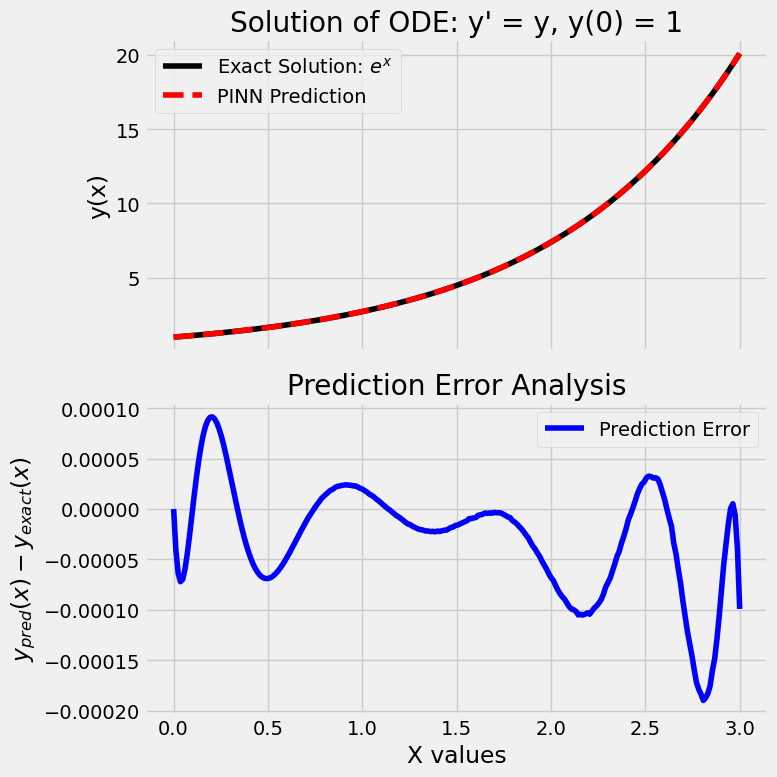

In [10]:
# Predictions
x = np.linspace(0, 3, 250).reshape(-1, 1)
y_pred = model.predict(x)

# Analytical solution
y_exact = solution(x)

# Plotting results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8, 8), sharex = True)

ax1.plot(x, y_exact, "k-", label = "Exact Solution: $e^x$")
ax1.plot(x, y_pred, "r--", label = "PINN Prediction")
ax1.set_ylabel("y(x)")
ax1.set_title("Solution of ODE: y' = y, y(0) = 1")
ax1.legend()
ax1.grid(True)

error = y_pred - y_exact
ax2.plot(x, error, "b-", label = "Prediction Error")
ax2.set_xlabel("X values")
ax2.set_ylabel("$y_{pred}(x) - y_{exact}(x)$")
ax2.set_title("Prediction Error Analysis")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

**Let's see now a second order differential equation that depends on time:**

\begin{equation*}
    y(t)'' - 10 \, y(t)' + 9 \, y(t) = 5 \, t
\end{equation*}

**With the following initial conditions:**

\begin{cases}
    y(0) = -1 \\
    y'(0) = 2
\end{cases}

In [11]:
# Defining the time domain from t = 0 to t = 0.3
domain = dde.geometry.TimeDomain(0, 0.3)

In [12]:
# Definig the ODE
def differential_equation(t, y):
    
    # First derivative: dy/dt
    dy_dt = dde.grad.jacobian(y, t, i = 0, j = 0)
    
    # Second derivative: d²y/dt²
    d2y_dt2 = dde.grad.hessian(y, t, i = 0, j = 0)
    
    # Returning the ODE residual
    return d2y_dt2 - 10 * dy_dt + 9 * y - 5 * t

### **DeepXDE `hessian` Function Documentation**  

### **Purpose**  
The `hessian` function computes **second-order partial derivatives** of a neural network's output with respect to its inputs, forming the **Hessian matrix** $H$, where:  
\begin{equation*}
    H[i, j] = \frac{\partial^2 y}{\partial x_i \partial x_j}
\end{equation*}
  
This is essential for solving **PDEs involving second-order derivatives** (e.g., Poisson equations, wave equations).

### **Parameters**  

| Parameter | Type | Description |  
|-----------|------|-------------|  
| `ys` | `Tensor` | Output tensor of shape `(batch_size, dim_y)` or `(batch_size_out, batch_size, dim_y)`. |  
| `xs` | `Tensor` | Input tensor of shape `(batch_size, dim_x)`. |  
| `component` | `int` | Selects `ys[:, component]` for differentiation (default: `0`). |  
| `i`, `j` | `int` | Indices specifying which partial derivative to compute (e.g., $\frac{\partial^2 y}{\partial x_0^2}$ for `i=0, j=0`). |  

### **Returns**  
| Output Shape | Description |  
|--------------|-------------|  
| `(batch_size, 1)` | For single-batch inputs. |  
| `(batch_size_out, batch_size, 1)` | For batched inputs. |  

### **Usage Examples**  

### **1. Basic Usage (1D Input)**  
Compute $\frac{d^2 y}{dx^2}$ for a scalar function $y(x)$:  
```python  
d2y_dx2 = dde.grad.hessian(y, x, i=0, j=0)  
```  

### **2. Multi-Dimensional Input**  
For $y(x_0, x_1)$, compute mixed partial derivative $\frac{\partial^2 y}{\partial x_0 \partial x_1}$:  
```python  
d2y_dx0dx1 = dde.grad.hessian(y, x, i=0, j=1)  
```  

### **3. Batched Outputs**  
For multiple outputs $[y_0, y_1]$, compute $\frac{\partial^2 y_1}{\partial x_0^2}$:  
```python  
d2y1_dx02 = dde.grad.hessian(y, x, component=1, i=0, j=0)  
```  
---

In [13]:
# Defining initial conditions
# First IC: y(0) = -1
ic_y = dde.icbc.IC(
                    geom = domain, 
                    func = lambda _: -1, 
                    on_initial = lambda _, on_initial: on_initial, 
                    component = 0
                    )

## Overview of `dde.icbc.IC` Class in DeepXDE

**Purpose and Functionality**

The `dde.icbc.IC` class in DeepXDE is designed to represent *initial conditions* for differential equation problems, particularly those involving time-dependent domains such as partial differential equations (PDEs) and ordinary differential equations (ODEs). This class allows users to specify the value of the solution at the initial time (or initial surface) of the computational domain.

**Class Signature**

```python
dde.icbc.IC(geom, func, on_initial, component=0)
```

**Parameters**

- `geom`: An instance of a DeepXDE geometry class (e.g., `TimeDomain`, `Rectangle`, etc.), defining the spatial and/or temporal domain of the problem.
- `func`: A function that specifies the initial value of the solution at the initial time or surface. It should take the input coordinates (e.g., `[x, t0]`) and return the corresponding initial value.
- `on_initial`: A function that determines whether a given point lies on the initial surface (e.g., at \( t = t_0 \)). Typically, this is used to select points where the initial condition should be enforced.
- `component` (optional): An integer specifying which component of the output the initial condition applies to, for systems with multiple outputs. Default is 0.

**Key Methods**

- `collocation_points(X)`: Returns the points where the initial condition is enforced.
- `error(X, inputs, outputs, beg, end)`: Computes the loss associated with the initial condition, comparing the model's output to the specified initial values at the relevant points.
- `filter(X)`: Filters the input points to select those that satisfy the initial condition criteria.

This object can then be passed to the data class (e.g., `dde.data.PDE`) as part of the list of conditions to enforce during training.

**Summary Table**

| Attribute/Method      | Description                                                                 |
|----------------------|-----------------------------------------------------------------------------|
| `geom`               | Geometry of the domain                                                      |
| `func`               | Function specifying initial value                                           |
| `on_initial`         | Function to identify initial points                                         |
| `component`          | Output component index (default 0)                                          |
| `collocation_points` | Returns points where the initial condition is applied                       |
| `error`              | Computes loss for initial condition                                         |
| `filter`             | Selects points satisfying the initial condition                             |

In [14]:
# Second IC: y'(0) = 2 (requires special handling)
def derivative_error(inputs, outputs, X):
    return dde.grad.jacobian(outputs, inputs, i = 0, j = None) - 2

def is_left_boundary(t, on_boundary):
    return on_boundary and np.isclose(t[0], 0)

ic_dy = dde.icbc.OperatorBC(
                            geom = domain,
                            func = derivative_error,
                            on_boundary = is_left_boundary
                            )

## Overview of `dde.icbc.OperatorBC` Class in DeepXDE

The `dde.icbc.OperatorBC` class in DeepXDE is a versatile utility for specifying boundary conditions (BCs) or initial conditions (ICs) in scientific machine learning problems, particularly those involving differential equations. This class allows users to define custom operator-based constraints that can be applied at specific boundaries or initial surfaces within the computational domain .

### Purpose and Functionality

The `OperatorBC` class enables users to enforce conditions where a user-defined operator acting on the solution must equal zero (or another specified value). These conditions are typically used to describe physical constraints such as Neumann boundary conditions, Robin boundary conditions, or other complex relationships between derivatives and the solution itself. It is especially useful when standard Dirichlet or Neumann boundary conditions are insufficient to describe the problem accurately .

### Class Signature

```python
dde.icbc.OperatorBC(geom, func, on_boundary)
```

### Parameters

- **`geom`**: An instance of a DeepXDE geometry class (e.g., `Interval`, `TimeDomain`, `GeometryXTime`, etc.) that defines the spatial and/or temporal domain of the problem .
  
- **`func`**: A function representing the operator condition. This function typically takes three arguments:
  - `x`: The input coordinates where the condition is evaluated.
  - `y`: The network output (solution) at the given coordinates.
  - `_`: Auxiliary variables (if any).
  The function should return the value of the operator, which is constrained to be zero (or another target value) at the specified boundary or surface .

- **`on_boundary`**: A function that determines whether a given point lies on the boundary or surface where the condition should be enforced. Typically, this is used to filter points based on their spatial or temporal coordinates .

In [15]:
# Configuring the ODE
data = dde.data.TimePDE(
                        geometryxtime = domain,
                        pde = differential_equation,
                        ic_bcs = [ic_y, ic_dy],
                        train_distribution = 'Hammersley',
                        num_domain = 1000,  
                        num_boundary = 2,    
                        num_test = 200   
                        )

In [16]:
# Building the neural network
network = dde.nn.FNN(
                    layer_sizes = [1] + [50] * 3 + [1], # 1 input, 3 hidden layers (50 units), 1 output
                    activation = "tanh",
                    kernel_initializer = "Glorot uniform"
                    )

In [17]:
# Creating the model, compiling and training it twice
model = dde.Model(
                  data = data,
                  net = network
                  )

model.compile(
              optimizer = "adam",
              lr = 1e-03,
              verbose = 1
              )

model.train(iterations = 15_000)

model.compile(optimizer = "L-BFGS")
model.train()

Compiling model...
'compile' took 0.001803 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.95e+00, 1.00e+00, 3.73e+00]    [1.95e+00, 1.00e+00, 3.73e+00]    []  
1000      [3.50e-02, 2.30e+00, 2.31e+00]    [3.47e-02, 2.30e+00, 2.31e+00]    []  
2000      [4.54e-02, 2.28e+00, 2.31e+00]    [4.44e-02, 2.28e+00, 2.31e+00]    []  
3000      [4.71e-02, 2.28e+00, 2.31e+00]    [4.60e-02, 2.28e+00, 2.31e+00]    []  
4000      [4.99e-02, 2.27e+00, 2.31e+00]    [4.88e-02, 2.27e+00, 2.31e+00]    []  
5000      [7.84e-02, 1.64e+00, 1.82e+00]    [7.06e-02, 1.64e+00, 1.82e+00]    []  
6000      [8.73e-02, 1.61e-01, 2.27e-01]    [7.53e-02, 1.61e-01, 2.27e-01]    []  
7000      [2.70e-02, 1.36e-02, 2.12e-02]    [2.29e-02, 1.36e-02, 2.12e-02]    []  
8000      [1.71e-02, 3.34e-03, 4.90e-03]    [1.43e-02, 3.34e-03, 4.90e-03]    []  
9000      [1.10e-02, 1.45e-03, 2.27e-03]    [9.33e-03, 1.45e-03, 2.27e-03]    []  
10000     [4.12

(<deepxde.model.LossHistory at 0x2477ede16d0>,
 <deepxde.model.TrainState at 0x2477ede1450>)

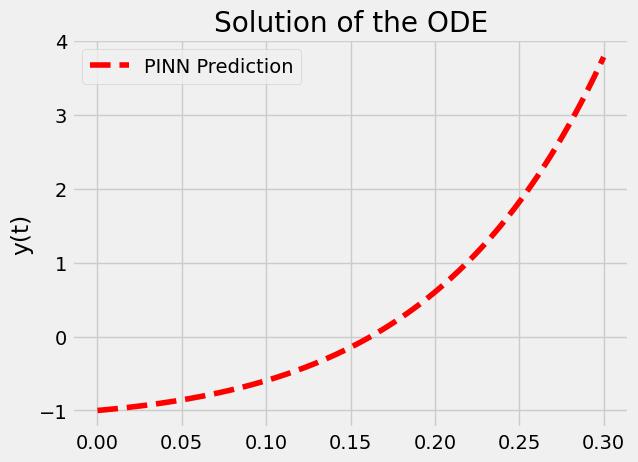

In [18]:
# Making Predictions
t = np.linspace(0, 0.3, 250).reshape(-1, 1)
y_pred = model.predict(t)

# Plotting results
plt.plot(t, y_pred, "r--", label = "PINN Prediction")
plt.ylabel("y(t)")
plt.title("Solution of the ODE")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Computing the exact solution
t = smp.symbols("t", real = True, nonnegative = True)
r = smp.Function("y", real = True)(t)

eq = smp.Eq(smp.diff(r, t, 2) - 10 * smp.diff(r, t, 1) + 9 * r, 5 * t)
ics = {
       r.subs(t, 0): -1,
       smp.diff(r, t, 1).subs(t, 0): 2
      }

sol = smp.dsolve(eq = eq, ics = ics, simplify = True)
sol

Eq(y(t), 5*t/9 + 31*exp(9*t)/81 - 2*exp(t) + 50/81)

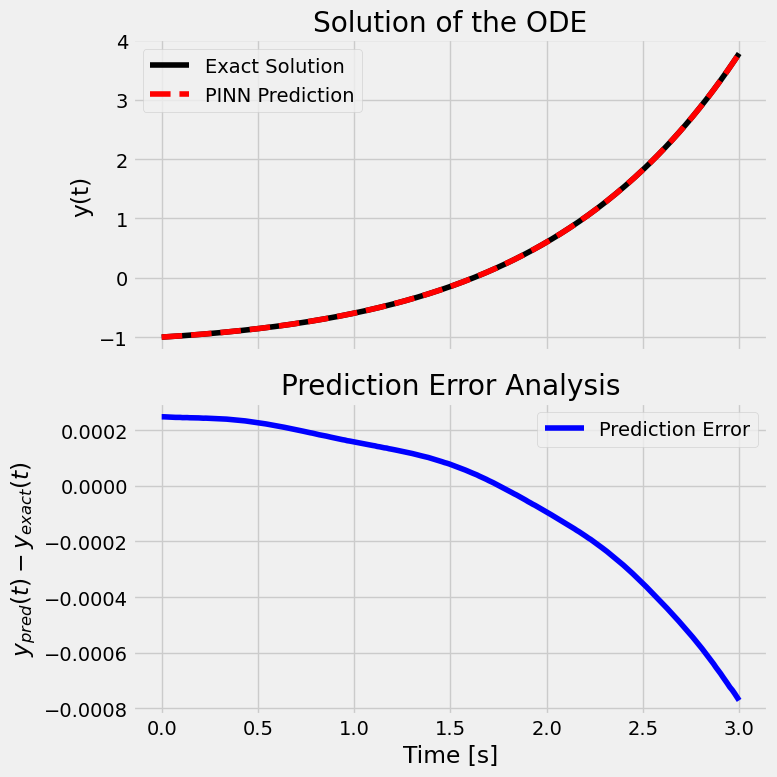

In [20]:
# Plotting the results
sol = smp.lambdify(t, sol.rhs, 'numpy')

t = np.linspace(0, 0.3, 250)
y_exact = sol(t)

# Plotting results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8, 8), sharex = True)

ax1.plot(x, y_exact, "k-", label = "Exact Solution")
ax1.plot(x, y_pred, "r--", label = "PINN Prediction")
ax1.set_ylabel("y(t)")
ax1.set_title("Solution of the ODE")
ax1.legend()
ax1.grid(True)

error = y_pred.reshape(-1) - y_exact
ax2.plot(x, error, "b-", label = "Prediction Error")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("$y_{pred}(t) - y_{exact}(t)$")
ax2.set_title("Prediction Error Analysis")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

**Let's see now how to solve a system of ordinary differential equations:**
\begin{cases}
    x'(t) = - 2 \, x(t) + y(t) \\
    y'(t) = x(t) - 2 \, y(t)
\end{cases}

**With initial conditions:**
\begin{cases}
    x(0) = 1 \\
    y(0) = 0
\end{cases}

In [21]:
# Defining the ODE system
def system(t, r):

    x = r[:, 0:1]  # Extract x component
    y = r[:, 1:]  # Extract y component
    
    dx_dt = dde.grad.jacobian(r, t, i = 0, j = 0)  # dx/dt
    dy_dt = dde.grad.jacobian(r, t, i = 1, j = 0)  # dy/dt
    
    # Defining the ODE residuals (these should equal zero)
    eq1 = dx_dt + 2 * x - y  # dx/dt = -2x + y
    eq2 = dy_dt - x + 2 * y  # dy/dt = x - 2y
    
    return [eq1, eq2]

In [22]:
# Defining the time interval from 0 to 5
time_domain = dde.geometry.TimeDomain(0, 5)

In [23]:
# Defining initial conditions
boundary = lambda _, on_boundary: on_boundary

# x(0) = 1
ic1 = dde.icbc.IC(
                  geom = time_domain,
                  func = lambda x: 1,
                  on_initial = boundary,
                  component = 0
                  )
# y(0) = 0
ic2 = dde.icbc.IC(
                  geom = time_domain,
                  func = lambda x: 0,
                  on_initial = boundary,
                  component = 1
                  )

In [24]:
# Creating the PDE data
data = dde.data.TimePDE(
                        geometryxtime = time_domain,
                        pde = system,
                        ic_bcs = [ic1, ic2],
                        num_domain = 1000,  # Number of training points in the domain
                        num_boundary = 2,  # Number of training points for initial conditions
                        num_test = 200 # Number of test points in the domain
                        )

In [25]:
# Defining the neural network
net = dde.nn.FNN(
                layer_sizes = [1] + [50] * 3 + [2], # 1 input, 3 hidden layers (50 units), 2 outputs
                activation = "tanh",
                kernel_initializer = "Glorot uniform"
                )

In [26]:
# Creating the model, compiling and training it
model = dde.Model(data, net)

model.compile(
              optimizer = "adam",
              lr = 0.1e-03
              )

model.train(iterations = 15_000)

model.compile("L-BFGS")
model.train()

Compiling model...
'compile' took 0.000909 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [8.17e-01, 1.64e+00, 1.00e+00, 0.00e+00]    [8.18e-01, 1.65e+00, 1.00e+00, 0.00e+00]    []  
1000      [1.88e-02, 1.98e-02, 5.51e-03, 5.74e-03]    [1.67e-02, 1.84e-02, 5.51e-03, 5.74e-03]    []  
2000      [3.53e-03, 4.58e-03, 1.94e-04, 2.23e-04]    [2.85e-03, 3.95e-03, 1.94e-04, 2.23e-04]    []  
3000      [1.28e-03, 1.16e-03, 1.57e-05, 1.87e-05]    [1.05e-03, 9.48e-04, 1.57e-05, 1.87e-05]    []  
4000      [5.42e-04, 3.94e-04, 2.57e-06, 3.21e-06]    [4.32e-04, 3.10e-04, 2.57e-06, 3.21e-06]    []  
5000      [2.23e-04, 1.31e-04, 5.62e-07, 6.58e-07]    [1.68e-04, 9.81e-05, 5.62e-07, 6.58e-07]    []  
6000      [1.27e-04, 4.74e-05, 1.35e-07, 1.46e-07]    [9.92e-05, 3.36e-05, 1.35e-07, 1.46e-07]    []  
7000      [1.37e-04, 4.48e-05, 2.38e-07, 1.08e-09]    [1.19e-04, 3.80e-05, 2.38e-07, 1.08e-09]    []  
8

(<deepxde.model.LossHistory at 0x24780449d10>,
 <deepxde.model.TrainState at 0x24780449bd0>)

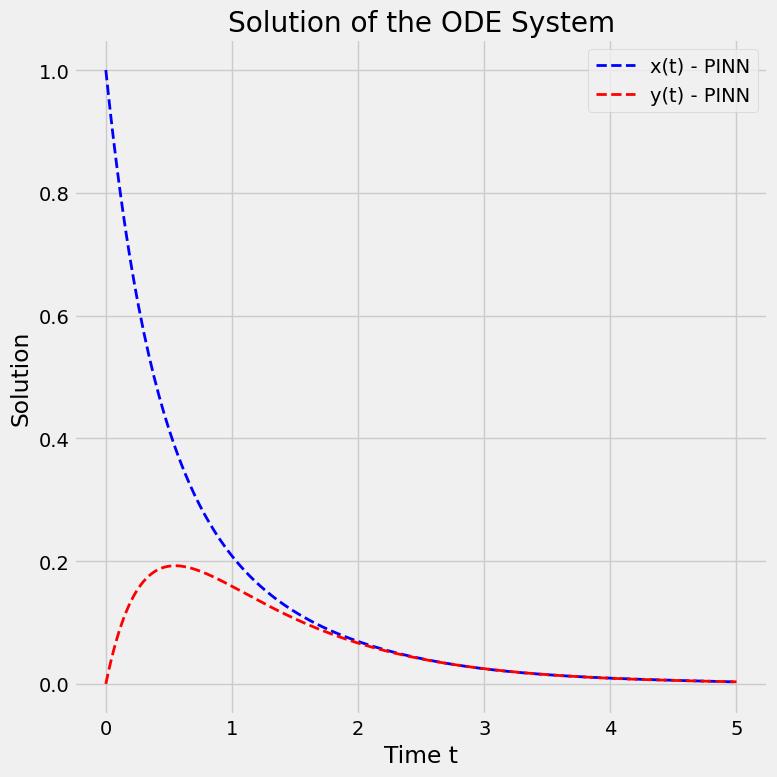

In [27]:
# Plotting the results
t = np.linspace(0, 5, 250).reshape(-1, 1)

predicted = model.predict(t)
x_pred = predicted[:, 0]
y_pred = predicted[:, 1]

plt.figure(figsize = (8, 8))

plt.plot(t, x_pred, 'b--', label = 'x(t) - PINN', linewidth = 2)
plt.plot(t, y_pred, 'r--', label = 'y(t) - PINN', linewidth = 2)
plt.xlabel('Time t')
plt.ylabel('Solution')
plt.title('Solution of the ODE System')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [28]:
# Finding the analytical solution of the system
t = smp.symbols("t", real = True)
x = smp.Function("x")(t)
y = smp.Function("y")(t)

eq1 = smp.Eq(smp.diff(x, t), - 2 * x + y)
eq2 = smp.Eq(smp.diff(y, t), x - 2 * y)

ics = {
    x.subs(t, 0): 1,
    y.subs(t, 0): 0
}

sol = smp.dsolve([eq1, eq2], [x, y], ics = ics)

In [29]:
# x(t)
sol[0]

Eq(x(t), exp(-t)/2 + exp(-3*t)/2)

In [30]:
# y(t)
sol[1]

Eq(y(t), exp(-t)/2 - exp(-3*t)/2)

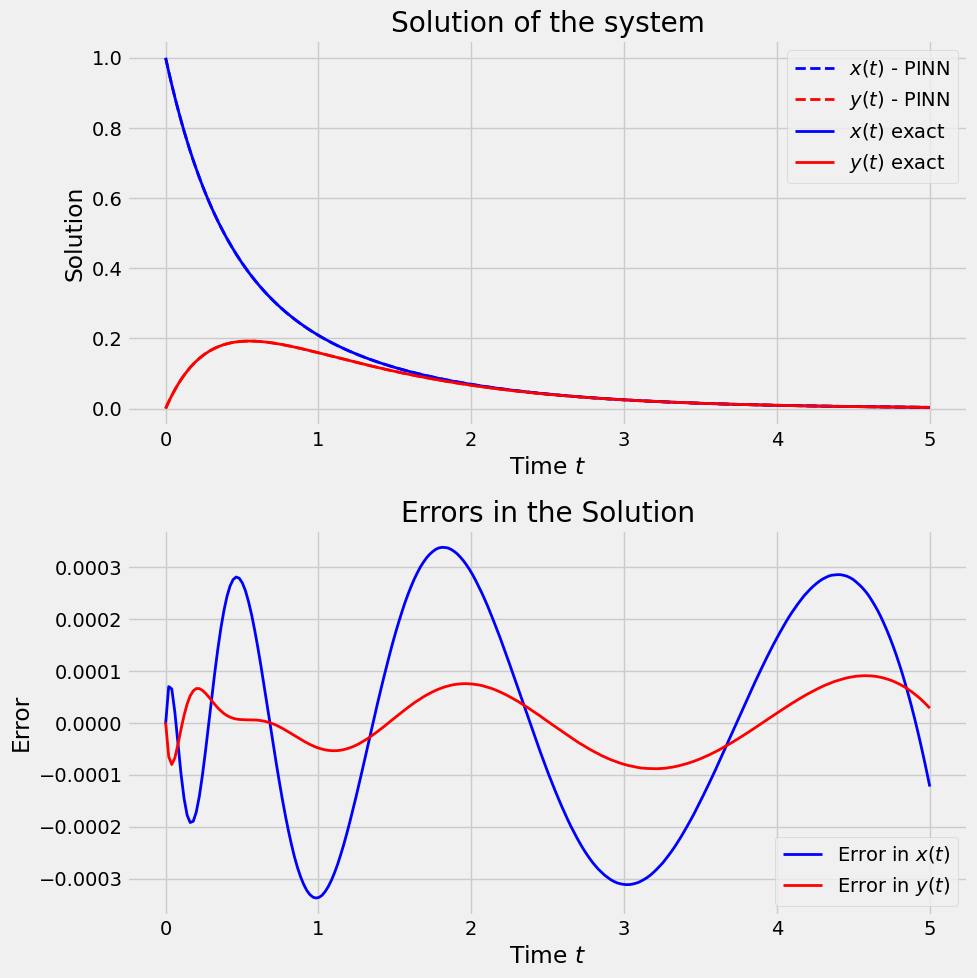

In [31]:
# Plotting results
x_exact = smp.lambdify(t, sol[0].rhs, 'numpy')
y_exact = smp.lambdify(t, sol[1].rhs, 'numpy')

t = np.linspace(0, 5, 250)
x_exact = x_exact(t)
y_exact = y_exact(t)

# Computing errors
error_x = x_pred - x_exact
error_y = y_pred - y_exact

fig, axs = plt.subplots(2, 1, figsize = (10, 10))

# First subplot: Solutions
axs[0].plot(t, x_pred, 'b--', label='$x(t)$ - PINN', linewidth = 2)
axs[0].plot(t, y_pred, 'r--', label='$y(t)$ - PINN', linewidth = 2)
axs[0].plot(t, x_exact, 'b-', label='$x(t)$ exact', linewidth = 2)
axs[0].plot(t, y_exact, 'r-', label='$y(t)$ exact', linewidth = 2)
axs[0].set_xlabel('Time $t$')
axs[0].set_ylabel('Solution')
axs[0].set_title('Solution of the system')
axs[0].legend()
axs[0].grid(True)

# Second subplot: Errors
axs[1].plot(t, error_x, 'b-', label='Error in $x(t)$', linewidth = 2)
axs[1].plot(t, error_y, 'r-', label='Error in $y(t)$', linewidth = 2)
axs[1].set_xlabel('Time $t$')
axs[1].set_ylabel('Error')
axs[1].set_title('Errors in the Solution')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()